https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

In [1]:
import os
from os.path import join as pjoin

import time
import numpy as np
import copy
import matplotlib.pyplot as plt

---

In [2]:
import torch
from torch.utils.data import DataLoader

In [3]:
import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder

In [4]:
# !wget -c https://download.pytorch.org/tutorial/hymenoptera_data.zip

In [5]:
data_transforms = {
    'train': transforms.Compose([ # augmentation and normalization for training
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([ # normalization for validation
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [6]:
data_dir = 'hymenoptera_data'

image_datasets = { x: ImageFolder( pjoin(data_dir,x), data_transforms[x]) for x in ['train', 'val'] }

dataloaders = {
    x: DataLoader(image_datasets[x],batch_size=32,shuffle=True,num_workers=4)
    for x in ['train', 'val']
}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

class_names = image_datasets['train'].classes

dataset_sizes

{'train': 244, 'val': 153}

In [7]:
x, y = next(iter(dataloaders['train']))
x,y = x.detach().numpy(), y.detach().numpy()
x.shape, y.shape

((32, 3, 224, 224), (32,))

In [8]:
# преобразуем тензор датасета в картинки
def tensor2img(t):
    im = np.transpose( t, (0, 2, 3, 1))
    im_mx,im_mn = im.max(axis=(1,2,3),keepdims=1),im.min(axis=(1,2,3),keepdims=1)
    return ((im-im_mn)/(im_mx-im_mn)*255.).astype(np.uint8)

x = tensor2img(x)
x.shape

(32, 224, 224, 3)

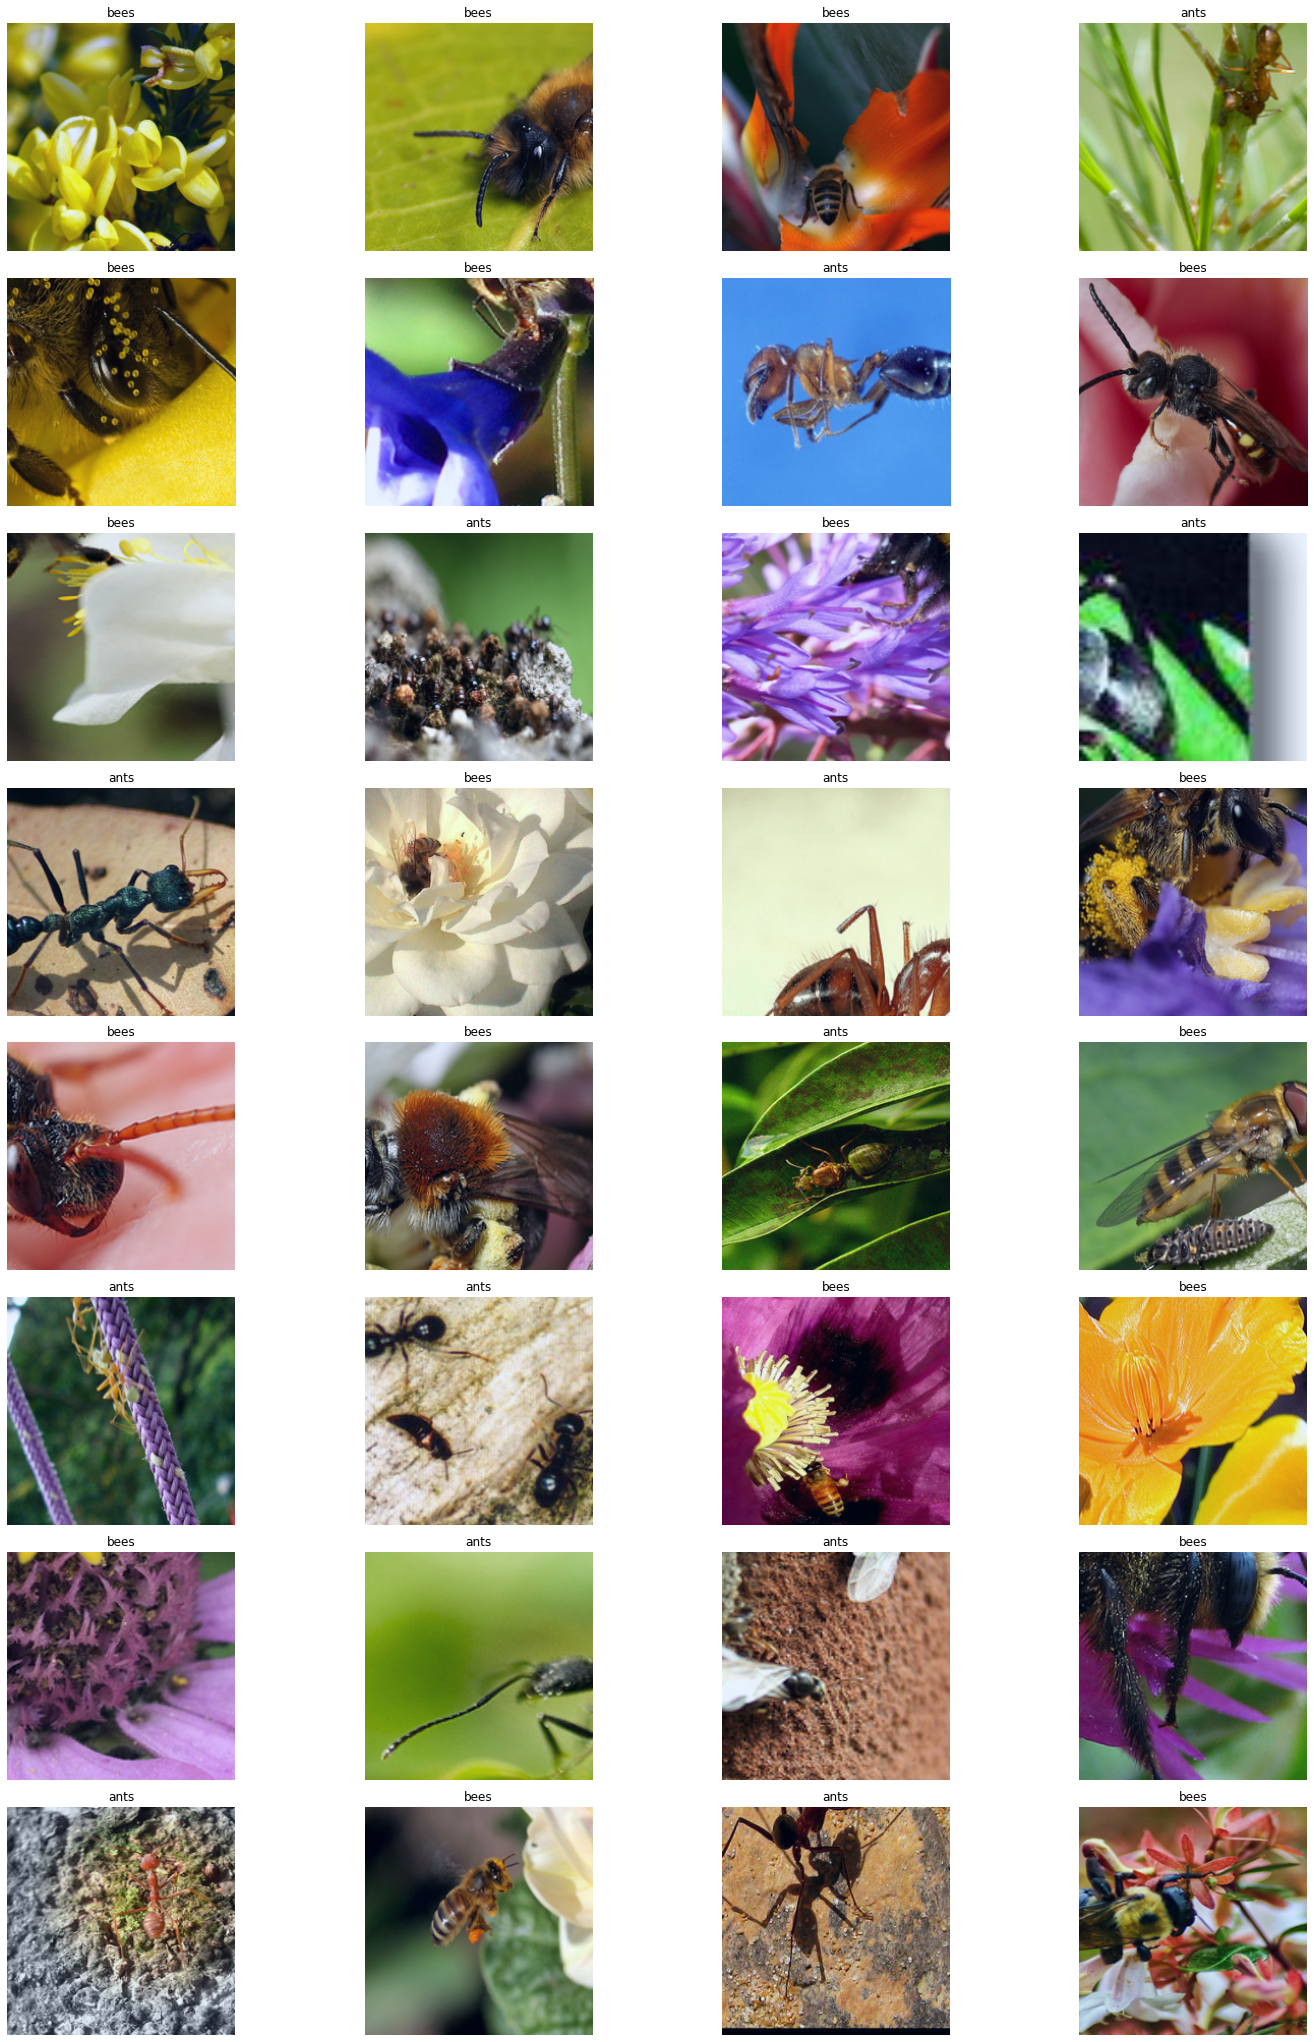

In [9]:
n_img = x.shape[0]
col = 4

fig = plt.figure(figsize=(20,32))
for n in range(n_img):
    img = x[n,:]
    s = class_names[y[n]]
    plt.subplot(n_img//col+1,col,n+1)
    plt.axis(False)
    plt.title(s)
    plt.imshow(img)
fig.tight_layout()    

---

In [10]:
from torchvision.models import resnet18

model0 = resnet18(pretrained=True)
for param in model0.parameters():
    param.requires_grad = False

In [11]:
model0

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [12]:
# num_ftrs = model_conv.fc.in_features
# model_conv.fc = nn.Linear(num_ftrs, 2)

In [13]:
# import torch.nn as nn
from torch.nn import Sequential
from torch.nn import Linear
from torch.nn import ReLU
from torch.nn import Softmax

In [14]:
num_ftrs = model0.fc.in_features

model0.fc = Sequential(
    Linear(num_ftrs, 256),
    ReLU(),
    Linear(256, 2),
    Softmax(dim=1)
)

In [15]:
model0

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [16]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# device = 'cpu'

In [17]:
model0 = model0.to(device)

In [18]:
from torch.nn import CrossEntropyLoss 
from torch.optim import SGD
from torch.optim import lr_scheduler

In [19]:
criterion0 = CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as opposed to before.
optimizer0 = SGD(model0.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer0, step_size=7, gamma=0.1)

In [20]:
def train_epoch(
        model=model0, 
        dataloader=dataloaders['train'], 
        dataset_size = dataset_sizes['train'],
        optimizer=optimizer0, 
        criterion = criterion0,
        scheduler=exp_lr_scheduler
    ):
    running_loss = 0.0
    model.train()
    for inputs, labels in dataloader:
        inputs,labels  = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()*inputs.size(0)
    scheduler.step()
    epoch_loss = running_loss / dataset_size
    
    return epoch_loss,model 
    


In [21]:
def val_epoch(
        model=model0, 
        dataloader=dataloaders['val'], 
        dataset_size = dataset_sizes['val'],
        optimizer=optimizer0, 
        criterion = criterion0,
        scheduler=exp_lr_scheduler
    ):
    running_loss = 0.0
    running_corrects = 0
    model.eval()
    for inputs, labels in dataloader:
        inputs,labels  = inputs.to(device), labels.to(device)
        with torch.set_grad_enabled(False): 
            outputs = model(inputs)
        _, preds = torch.max(outputs, 1)    
        loss = criterion(outputs, labels)
        running_loss += loss.item()*inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
    scheduler.step()
    epoch_loss = running_loss / dataset_size
    epoch_acc = running_corrects.double() / dataset_size
    return epoch_loss,epoch_acc.cpu().detach().numpy()

In [ ]:
%%time

train_loss_hist = []
val_loss_hist = []
val_acc_hist = []

for ep in range(20):
    train_loss, model0 = train_epoch(model=model0)
    val_loss, val_acc = val_epoch(model=model0)
    print('%i : train loss:%.3f, val loss:%.3f, val acc: %.3f'%(ep,train_loss,val_loss,val_acc))
    
    train_loss_hist.append(train_loss)
    val_loss_hist.append(val_loss)
    val_acc_hist.append(val_acc)
    # print(type(val_acc))

0 : train loss:0.693, val loss:0.692, val acc: 0.497
1 : train loss:0.676, val loss:0.668, val acc: 0.660
2 : train loss:0.663, val loss:0.643, val acc: 0.810
3 : train loss:0.640, val loss:0.624, val acc: 0.843
4 : train loss:0.633, val loss:0.623, val acc: 0.856
5 : train loss:0.636, val loss:0.622, val acc: 0.863
6 : train loss:0.633, val loss:0.620, val acc: 0.863
7 : train loss:0.628, val loss:0.620, val acc: 0.876
8 : train loss:0.628, val loss:0.621, val acc: 0.863
9 : train loss:0.635, val loss:0.620, val acc: 0.863
10 : train loss:0.631, val loss:0.619, val acc: 0.869
11 : train loss:0.625, val loss:0.619, val acc: 0.869
12 : train loss:0.633, val loss:0.619, val acc: 0.863
13 : train loss:0.626, val loss:0.620, val acc: 0.869
14 : train loss:0.626, val loss:0.620, val acc: 0.856
15 : train loss:0.632, val loss:0.619, val acc: 0.863
16 : train loss:0.630, val loss:0.620, val acc: 0.863
17 : train loss:0.630, val loss:0.620, val acc: 0.863
18 : train loss:0.624, val loss:0.619,

In [ ]:
plt.plot(train_loss_hist)
plt.plot(val_loss_hist)

In [ ]:
plt.plot(val_acc_hist)

In [ ]:
# model.eval()
# running_loss = 0.0
# for inputs, labels in dataloaders['val']:
#     inputs,labels  = inputs.to(device), labels.to(device)
#     with torch.set_grad_enabled(False):
#         outputs = model(inputs)
#         _, preds = torch.max(outputs, 1)
#         loss = criterion(outputs, labels)
        
#         running_loss += loss.item() * inputs.size(0)
#         running_corrects += torch.sum(preds == labels.data)
            
            
#     running_corrects += torch.sum(preds == labels.data)
            
#     epoch_loss = running_loss / dataset_sizes['val']
#     epoch_acc = running_corrects.double() / dataset_sizes['val']
            

In [ ]:
# # def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
# # since = time.time()
# # best_model_wts = copy.deepcopy(model.state_dict())
# # best_acc = 0.0

# for epoch in range(num_epochs):
#     print('Epoch {}/{}'.format(epoch, num_epochs - 1))
#     print('-' * 10)

#     # Each epoch has a training and validation phase
#     for phase in ['train', 'val']:
#         if phase == 'train':
#             model.train()  # Set model to training mode
#         else:
#             model.eval()   # Set model to evaluate mode

#         running_loss = 0.0
#         running_corrects = 0

#         # Iterate over data.
#         for inputs, labels in dataloaders[phase]:
#             inputs = inputs.to(device)
#             labels = labels.to(device)

#             # zero the parameter gradients
#             optimizer.zero_grad()

#             # forward
#             # track history if only in train
#             with torch.set_grad_enabled(phase == 'train'):
#                 outputs = model(inputs)
#                 _, preds = torch.max(outputs, 1)
#                 loss = criterion(outputs, labels)

#                 # backward + optimize only if in training phase
#                 if phase == 'train':
#                     loss.backward()
#                     optimizer.step()

#             # statistics
#             running_loss += loss.item() * inputs.size(0)
#             running_corrects += torch.sum(preds == labels.data)
            
#         if phase == 'train':
#             scheduler.step()

#         epoch_loss = running_loss / dataset_sizes[phase]
#         epoch_acc = running_corrects.double() / dataset_sizes[phase]

#         print('{} Loss: {:.4f} Acc: {:.4f}'.format(
#             phase, epoch_loss, epoch_acc))

#         # deep copy the model
#         if phase == 'val' and epoch_acc > best_acc:
#             best_acc = epoch_acc
#             best_model_wts = copy.deepcopy(model.state_dict())

#     print()

# time_elapsed = time.time() - since
# print('Training complete in {:.0f}m {:.0f}s'.format(
#     time_elapsed // 60, time_elapsed % 60))
# print('Best val Acc: {:4f}'.format(best_acc))

# # load best model weights
# model.load_state_dict(best_model_wts)
# return model

In [ ]:
# model_ft = models.resnet18(pretrained=True)
# num_ftrs = model_ft.fc.in_features
# # Here the size of each output sample is set to 2.
# # Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
# model_ft.fc = nn.Linear(num_ftrs, 2)

# model_ft = model_ft.to(device)

# criterion = nn.CrossEntropyLoss()

# # Observe that all parameters are being optimized
# optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# # Decay LR by a factor of 0.1 every 7 epochs
# exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

---

In [ ]:
# def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
#     since = time.time()

#     best_model_wts = copy.deepcopy(model.state_dict())
#     best_acc = 0.0

#     for epoch in range(num_epochs):
#         print('Epoch {}/{}'.format(epoch, num_epochs - 1))
#         print('-' * 10)

#         # Each epoch has a training and validation phase
#         for phase in ['train', 'val']:
#             if phase == 'train':
#                 model.train()  # Set model to training mode
#             else:
#                 model.eval()   # Set model to evaluate mode

#             running_loss = 0.0
#             running_corrects = 0

#             # Iterate over data.
#             for inputs, labels in dataloaders[phase]:
#                 inputs = inputs.to(device)
#                 labels = labels.to(device)

#                 # zero the parameter gradients
#                 optimizer.zero_grad()

#                 # forward
#                 # track history if only in train
#                 with torch.set_grad_enabled(phase == 'train'):
#                     outputs = model(inputs)
#                     _, preds = torch.max(outputs, 1)
#                     loss = criterion(outputs, labels)

#                     # backward + optimize only if in training phase
#                     if phase == 'train':
#                         loss.backward()
#                         optimizer.step()

#                 # statistics
#                 running_loss += loss.item() * inputs.size(0)
#                 running_corrects += torch.sum(preds == labels.data)
#             if phase == 'train':
#                 scheduler.step()

#             epoch_loss = running_loss / dataset_sizes[phase]
#             epoch_acc = running_corrects.double() / dataset_sizes[phase]

#             print('{} Loss: {:.4f} Acc: {:.4f}'.format(
#                 phase, epoch_loss, epoch_acc))

#             # deep copy the model
#             if phase == 'val' and epoch_acc > best_acc:
#                 best_acc = epoch_acc
#                 best_model_wts = copy.deepcopy(model.state_dict())

#         print()

#     time_elapsed = time.time() - since
#     print('Training complete in {:.0f}m {:.0f}s'.format(
#         time_elapsed // 60, time_elapsed % 60))
#     print('Best val Acc: {:4f}'.format(best_acc))

#     # load best model weights
#     model.load_state_dict(best_model_wts)
#     return model

In [ ]:
# def visualize_model(model, num_images=6):
#     was_training = model.training
#     model.eval()
#     images_so_far = 0
#     fig = plt.figure()

#     with torch.no_grad():
#         for i, (inputs, labels) in enumerate(dataloaders['val']):
#             inputs = inputs.to(device)
#             labels = labels.to(device)

#             outputs = model(inputs)
#             _, preds = torch.max(outputs, 1)

#             for j in range(inputs.size()[0]):
#                 images_so_far += 1
#                 ax = plt.subplot(num_images//2, 2, images_so_far)
#                 ax.axis('off')
#                 ax.set_title('predicted: {}'.format(class_names[preds[j]]))
#                 imshow(inputs.cpu().data[j])

#                 if images_so_far == num_images:
#                     model.train(mode=was_training)
#                     return
#         model.train(mode=was_training)

---

In [ ]:
# model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,  num_epochs=25)

In [ ]:
# visualize_model(model_ft)

---

---

ConvNet as fixed feature extractor   

Here, we need to freeze all the network except the final layer.   
We need to set ``requires_grad == False`` to freeze the parameters   
so that the gradients are not computed in ``backward()``.  

You can read more about this in the documentation   
`here <https://pytorch.org/docs/notes/autograd.html#excluding-subgraphs-from-backward>`

In [ ]:
# model_conv = torchvision.models.resnet18(pretrained=True)
# for param in model_conv.parameters():
#     param.requires_grad = False

In [ ]:
# # Parameters of newly constructed modules have requires_grad=True by default
# num_ftrs = model_conv.fc.in_features

# model_conv.fc = nn.Linear(num_ftrs, 2)
# model_conv = model_conv.to(device)
# criterion = nn.CrossEntropyLoss()

# # Observe that only parameters of final layer are being optimized as opposed to before.
# optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# # Decay LR by a factor of 0.1 every 7 epochs
# exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [ ]:
# model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=25)

In [ ]:
# visualize_model(model_conv)

# plt.ioff()
# plt.show()